# Statistical analysis of each model

In [197]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

# add regular stat for skeptics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

# import bambi
import bambi as bm

In [198]:
# grab data
df = pd.read_csv('../scr_amg_hipp_all.csv')

In [199]:
df.head(10)

sub  Condition  Event.Nr  CDA.AmpSum  expected_value        pe     scr  \
0  sub-189  CSplusUS1         1      0.2852        0.775073  0.500000  0.2852   
1  sub-189   CSminus1         2      0.1033        0.772940 -0.500000  0.1033   
2  sub-189    CSplus1         3      0.0783        0.774003 -0.500680  0.0783   
3  sub-189  CSplusUS1         4      0.1772        0.775070  0.500002  0.1772   
4  sub-189   CSminus1         5      0.0000        0.771878 -0.499320  0.0000   
5  sub-189    CSplus1         6      0.0000        0.774000 -0.500678  0.0000   
6  sub-189    CSplus1         7      0.0000        0.772933 -0.499995  0.0000   
7  sub-189   CSminus1         8      0.0000        0.770818 -0.498642  0.0000   
8  sub-189  CSplusUS1         9      0.2063        0.774003  0.500684  0.2063   
9  sub-189   CSminus1        10      0.0000        0.769763 -0.497967  0.0000   

   index  subject  trialNo  condition  coupling       amg      Sub group  \
0   1794  sub-189        1  CSplusUS1  0.309524  0.981121  sub-189    HC   
1   1795  sub-189        2   CSminus1 -0.571429 -0.027048  sub-189    HC   
2   1796  sub-189        3    CSplus1 -0.476190 -0.045910  sub-189    HC   
3   1797  sub-189        4  CSplusUS1  0.166667 -0.674150  sub-189    HC   
4   1798  sub-189        5   CSminus1  0.214286 -0.065602  sub-189    HC   
5   1799  sub-189        6    CSplus1 -0.690476 -0.398827  sub-189    HC   
6   1800  sub-189        7    CSplus1  0.285714 -0.104992  sub-189    HC   
7   1801  sub-189        8   CSminus1 -0.404762 -0.423804  sub-189    HC   
8   1802  sub-189        9  CSplusUS1  0.071429  0.154643  sub-189    HC   
9   1803  sub-189       10   CSminus1 -0.571429 -0.164440  sub-189    HC   

  Eprime  amg_vmpfc  amg_HippAnt  
0      A   0.904762     0.571429  
1      A   0.404762    -0.119048  
2      A   0.333333    -0.642857  
3      A   0.690476     0.357143  
4      A   0.595238     0.309524  
5      A   0.428571    -0.238095  
6      A  -0.023810    -0.071429  
7      A  -0.047619    -0.190476  
8      A   0.571429     0.047619  
9      A   0.119048    -0.238095

In [200]:
df.coupling.std()

0.43208726413391557

<AxesSubplot:xlabel='scr', ylabel='Count'>

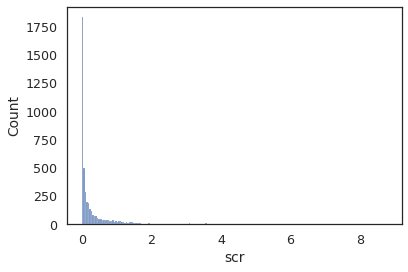

In [201]:
sns.histplot(df.scr)

<AxesSubplot:xlabel='coupling', ylabel='Count'>

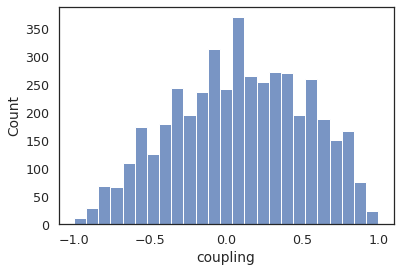

In [202]:
sns.histplot(df.coupling)

## Coupling predicted by condition 
- Hypothesis: CS+US will have higher coupling compared to CS+ and CS-

In [190]:
glm = smf.mixedlm('coupling ~ C(condition) + trialNo+ amg', data=df, 
    groups = 'subject', 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     coupling  
No. Observations:      4485        Method:                 REML      
No. Groups:            65          Scale:                  0.1498    
Min. group size:       69          Log-Likelihood:         -2223.1579
Max. group size:       69          Converged:              Yes       
Mean group size:       69.0                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.014    0.029  0.495 0.620 -0.042  0.070
C(condition)[T.CSminus2]   -0.045    0.027 -1.632 0.103 -0.099  0.009
C(condition)[T.CSminusUS2]  0.038    0.029  1.339 0.181 -0.018  0.094
C(condition)[T.CSplus1]    -0.022    0.020 -1.114 0.265 -0.060  0.017
C(condition)[T.CSplus2]    -0.050   

In [203]:
# Bayes model
# organize data
df['sub'] = df['sub'].astype('category')
#df['condition'] = df['condition'].astype('category')

n_sub = len(df['sub'].unique())
subIDX = df['sub'].cat.codes.values
# condition
n_cond = len(df['condition'].unique())
#condIDX = df['condition'].cat.codes.values
trials = df.trialNo.values - 1
amygdala = df.amg.values
# trialNo
y = df.coupling.values - df.coupling.mean()

In [204]:
df['condition'].unique()

array(['CSplusUS1', 'CSminus1', 'CSplus1', 'CSminusUS2', 'CSplus2',
       'CSminus2'], dtype=object)

In [205]:
# generating condition index
df['cond'] = df['condition']#
df = df.replace(to_replace={'cond': {'CSminus1':0, 'CSplus1':1, 'CSplusUS1':2, 'CSplus2':3, 'CSminus2':4, 'CSminusUS2':5}})

In [206]:
condIDX = df.cond.values

In [16]:
# start simple
with pm.Model() as model1:
    a = pm.Normal('a', mu=0, sigma=2)
    b = pm.Normal('b', mu=0, sigma=2, shape=1)
    
    eps = pm.HalfCauchy('eps', 5)
    mu = a + b*condIDX
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=y)
    
    trace1 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 10 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

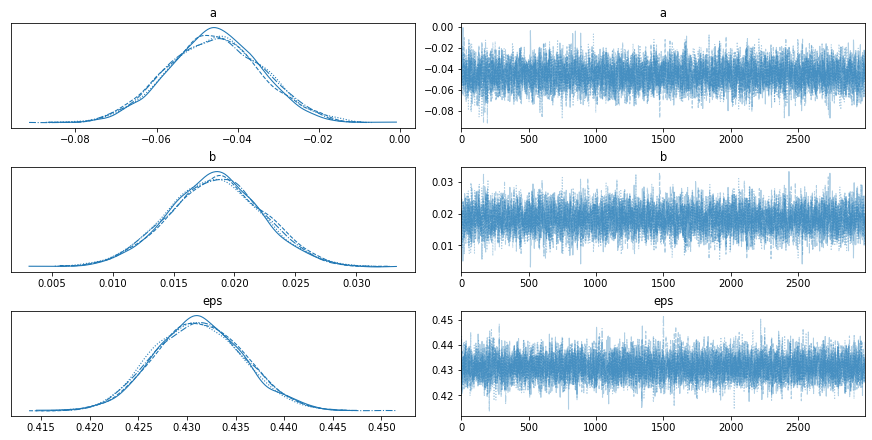

In [17]:
az.plot_trace(trace1)

In [18]:
az.summary(trace1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a    -0.046  0.012  -0.067   -0.023        0.0      0.0    5105.0    5581.0   
b[0]  0.018  0.004   0.011    0.026        0.0      0.0    5169.0    6068.0   
eps   0.431  0.005   0.423    0.440        0.0      0.0    6407.0    6327.0   

      r_hat  
a       1.0  
b[0]    1.0  
eps     1.0

In [14]:
# give random intercept
with pm.Model() as model2:
    a = pm.Normal('a', mu=0, sigma=2, shape=n_sub)
    b = pm.Normal('b', mu=0, sigma=2, shape=1)
    
    eps = pm.HalfCauchy('eps', 5)
    mu = a[subIDX] + b*condIDX
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace2 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

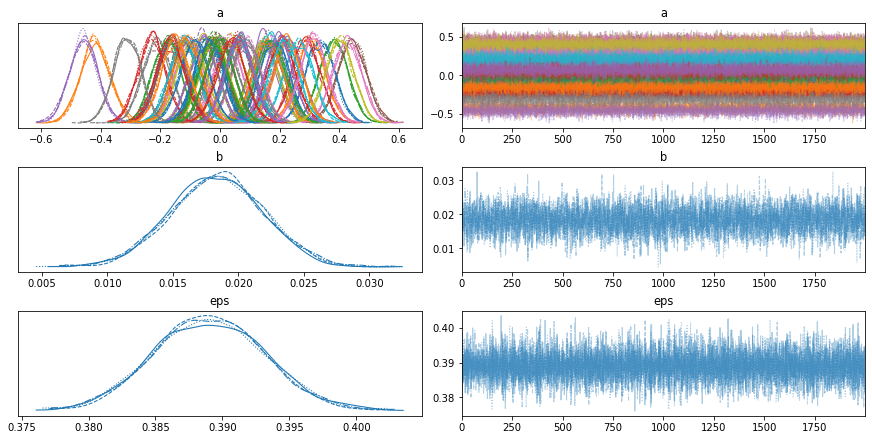

In [15]:
az.plot_trace(trace2)

In [16]:
az.summary(trace2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0]   0.062  0.048  -0.031    0.151        0.0    0.000   17449.0    5477.0   
a[1]  -0.419  0.049  -0.511   -0.327        0.0    0.000   16661.0    5251.0   
a[2]   0.382  0.047   0.294    0.470        0.0    0.000   18243.0    6020.0   
a[3]   0.068  0.048  -0.022    0.157        0.0    0.000   15188.0    4969.0   
a[4]   0.145  0.048   0.057    0.237        0.0    0.000   17471.0    5602.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
a[62] -0.001  0.048  -0.089    0.090        0.0    0.001   16790.0    5755.0   
a[63]  0.037  0.048  -0.049    0.131        0.0    0.000   16174.0    5474.0   
a[64]  0.065  0.046  -0.023    0.149        0.0    0.000   16702.0    6258.0   
b[0]   0.018  0.004   0.012    0.025        0.0    0.000    4602.0    6056.0   
eps    0.389  0.004   0.381    0.396        0.0    0.000   16216.0    5315.0   

       r_hat  
a[0]     1.0  
a[1]     1.0  
a[2]     1.0  
a[3]     1.0  
a[4]     1.0  
...      ...  
a[62]    1.0  
a[63]    1.0  
a[64]    1.0  
b[0]     1.0  
eps      1.0  

[67 rows x 9 columns]

In [18]:
# adding trials
# give random intercept
with pm.Model() as model3:
    a = pm.Normal('a', mu=0, sigma=2, shape=n_sub)
    b = pm.Normal('b', mu=0, sigma=2, shape=n_sub)
    #b2 = pm.Normal('b2', mu=0, sigma=2)#, shape=nTrials)
    eps = pm.HalfCauchy('eps', 5)
    mu = a[subIDX] + b[subIDX]*condIDX 
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace3 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=3000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 79 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

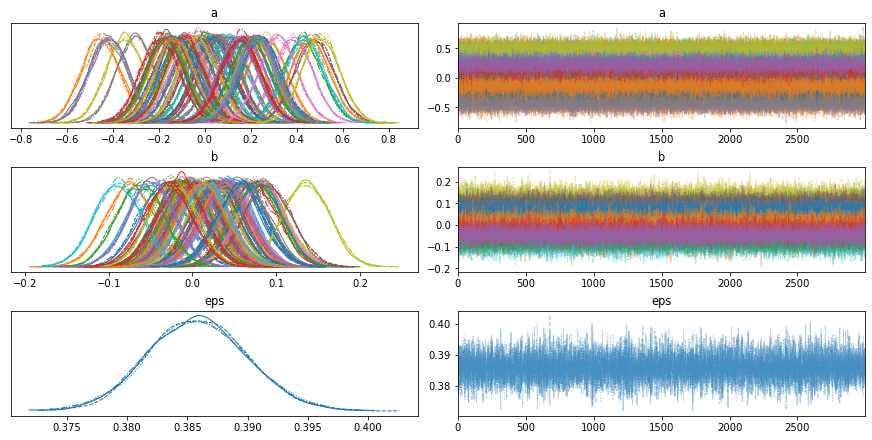

In [19]:
az.plot_trace(trace3)

In [20]:
az.compare({'model1': trace1, 'model2': trace2, 'model3': trace3})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank          loo       p_loo       d_loo    weight         se  \
model3     0 -2158.680307  128.457577    0.000000  0.541239  42.662611   
model2     1 -2162.813818   66.166858    4.133511  0.412477  41.861133   
model1     2 -2591.750047    2.644520  433.069740  0.046285  37.387080   

              dse  warning loo_scale  
model3   0.000000    False       log  
model2  12.000974    False       log  
model1  32.177007    False       log

In [50]:
with pm.Model() as model4:
    # hyper for condition
    b_cond = pm.Normal('b_cond', mu=0, sigma=.5, shape=n_cond)
   
    a = pm.Normal('a', mu=0, sigma=.5, shape=n_sub)
  
    eps = pm.HalfCauchy('eps', .5)
  
    mu = a[subIDX] + b_cond[condIDX]
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace4 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, a, b_cond]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

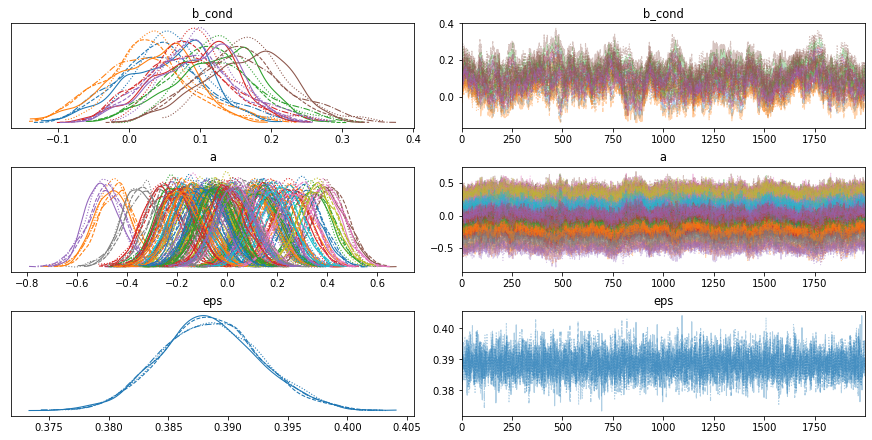

In [51]:
az.plot_trace(trace4)

In [52]:
az.summary(trace4, var_names='b_cond')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_cond[0]  0.052  0.060  -0.059    0.170      0.007    0.005      65.0   
b_cond[1]  0.029  0.060  -0.091    0.140      0.007    0.005      69.0   
b_cond[2]  0.120  0.062   0.006    0.242      0.007    0.006      71.0   
b_cond[3]  0.087  0.060  -0.030    0.195      0.008    0.005      64.0   
b_cond[4]  0.093  0.059  -0.023    0.204      0.007    0.005      67.0   
b_cond[5]  0.161  0.061   0.050    0.283      0.008    0.006      66.0   

           ess_tail  r_hat  
b_cond[0]     179.0   1.06  
b_cond[1]     184.0   1.06  
b_cond[2]     177.0   1.06  
b_cond[3]     191.0   1.06  
b_cond[4]     179.0   1.06  
b_cond[5]     175.0   1.06

In [41]:
az.compare({'model1': trace1, 'model2': trace2, 'model3': trace3, 'model4': trace4})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


rank          loo       p_loo       d_loo    weight         se  \
model4     0 -2158.470529   69.684394    0.000000  0.453698  41.736732   
model3     1 -2158.680307  128.457577    0.209778  0.507026  42.662611   
model2     2 -2162.813818   66.166858    4.343289  0.000000  41.861133   
model1     3 -2591.750047    2.644520  433.279518  0.039277  37.387080   

              dse  warning loo_scale  
model4   0.000000    False       log  
model3  12.679755    False       log  
model2   4.109188    False       log  
model1  29.954062    False       log

<AxesSubplot:>

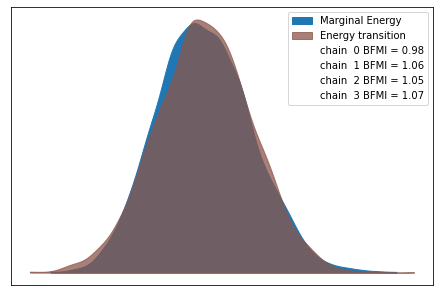

In [43]:
az.plot_energy(trace4)

In [59]:
# add hyperpriors
with pm.Model() as model5:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    
    b_cond = pm.Normal('b_cond', mu=mu_b, sigma=sigma_b, shape=n_cond)
   
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_sub)
  
    eps = pm.HalfCauchy('eps', .5)
  
    mu = a[subIDX] + b_cond[condIDX]
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace5 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, a, b_cond, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

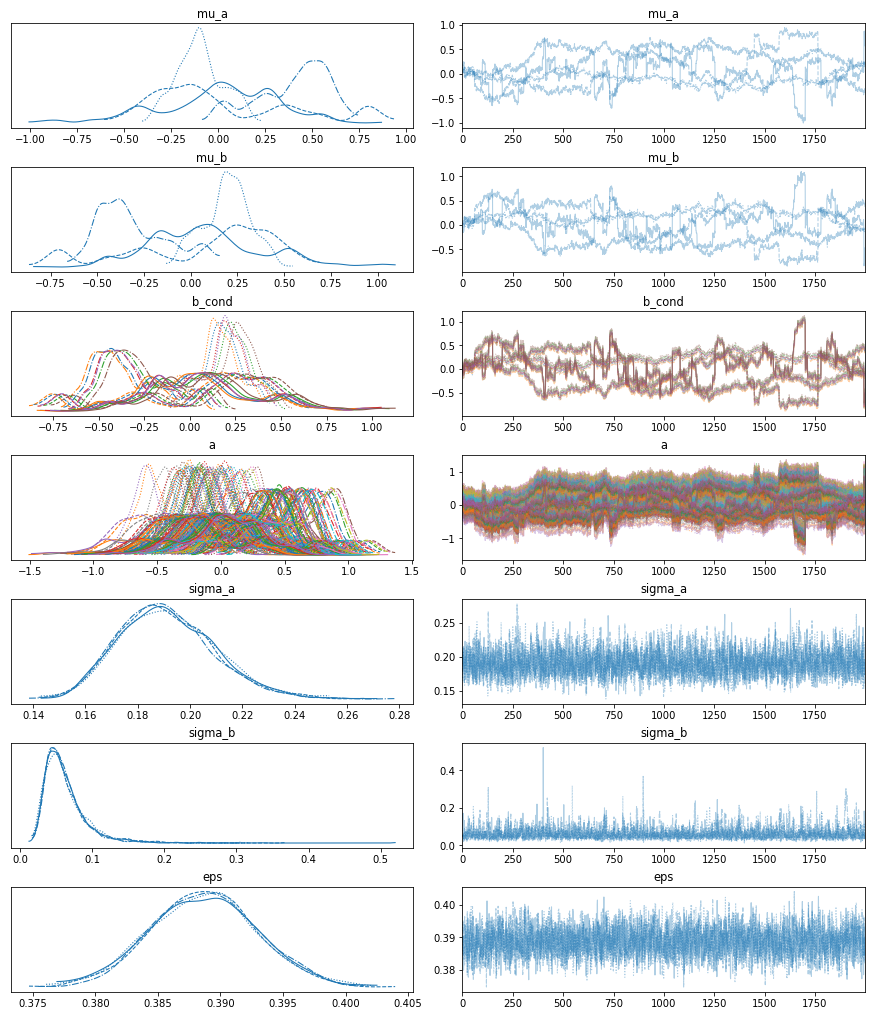

In [60]:
az.plot_trace(trace5)

In [62]:
az.compare({'model3': trace3, 'model4': trace4, 'model5':trace5})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/n

rank          loo       p_loo     d_loo    weight         se  \
model5     0 -2157.228343   66.436289  0.000000  0.503721  41.307746   
model4     1 -2158.524260   69.731959  1.295917  0.000000  41.728321   
model3     2 -2158.680307  128.457577  1.451964  0.496279  42.662611   

              dse  warning loo_scale  
model5   0.000000    False       log  
model4   1.651153    False       log  
model3  12.706554    False       log

In [20]:
# use reparametarization of the same model
# add hyperpriors
with pm.Model() as model6:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
   
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.coupling)
    
    trace6 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 480 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b_matt'}>,
        <AxesSubplot:title={'center':'b_matt'}>],
       [<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>]], dtype=object)

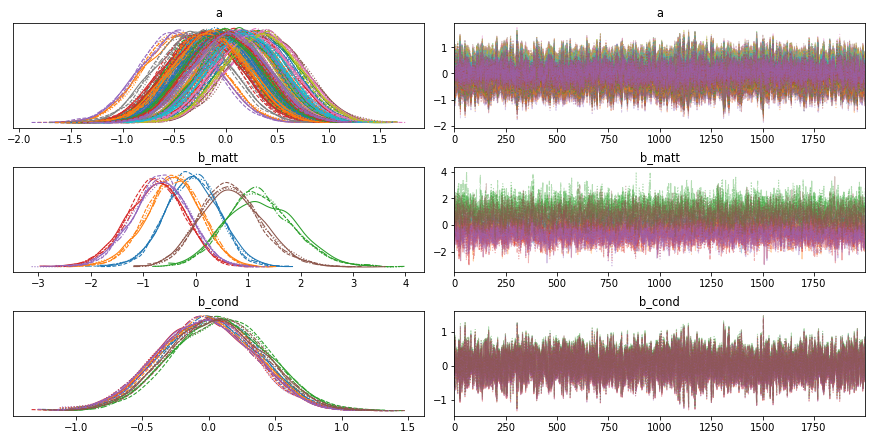

In [24]:
az.plot_trace(trace6, var_names=['a','b_matt','b_cond'])

In [25]:
az.summary(trace6, var_names=['b_cond','b_matt'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_cond[0]  0.009  0.358  -0.622    0.714      0.006    0.004    3179.0   
b_cond[1] -0.011  0.358  -0.664    0.672      0.006    0.004    3189.0   
b_cond[2]  0.082  0.358  -0.559    0.783      0.006    0.005    3159.0   
b_cond[3] -0.031  0.358  -0.677    0.661      0.006    0.004    3181.0   
b_cond[4] -0.026  0.358  -0.674    0.660      0.006    0.004    3170.0   
b_cond[5]  0.049  0.358  -0.603    0.731      0.006    0.005    3170.0   
b_matt[0] -0.068  0.511  -1.033    0.873      0.011    0.008    2276.0   
b_matt[1] -0.434  0.528  -1.391    0.572      0.012    0.008    2036.0   
b_matt[2]  1.229  0.655   0.023    2.463      0.013    0.009    2527.0   
b_matt[3] -0.758  0.549  -1.798    0.250      0.012    0.009    1937.0   
b_matt[4] -0.672  0.542  -1.733    0.284      0.012    0.009    1971.0   
b_matt[5]  0.675  0.593  -0.369    1.852      0.012    0.008    2578.0   

           ess_tail  r_hat  
b_cond[0]    4579.0    1.0  
b_cond[1]    4622.0    1.0  
b_cond[2]    4595.0    1.0  
b_cond[3]    4594.0    1.0  
b_cond[4]    4550.0    1.0  
b_cond[5]    4456.0    1.0  
b_matt[0]    3575.0    1.0  
b_matt[1]    3575.0    1.0  
b_matt[2]    4206.0    1.0  
b_matt[3]    3614.0    1.0  
b_matt[4]    3492.0    1.0  
b_matt[5]    4039.0    1.0

In [74]:
az.compare({'model3': trace3, 'model4': trace4, 'model5':trace5, 'model6':trace6})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/n

rank          loo       p_loo     d_loo        weight         se  \
model5     0 -2157.228343   66.436289  0.000000  5.037195e-01  41.307746   
model6     1 -2157.235262   66.535220  0.006919  0.000000e+00  41.347988   
model4     2 -2158.524260   69.731959  1.295917  1.110223e-16  41.728321   
model3     3 -2158.680307  128.457577  1.451964  4.962805e-01  42.662611   

              dse  warning loo_scale  
model5   0.000000    False       log  
model6   0.117187    False       log  
model4   1.651153    False       log  
model3  12.706554    False       log

array([<AxesSubplot:>], dtype=object)

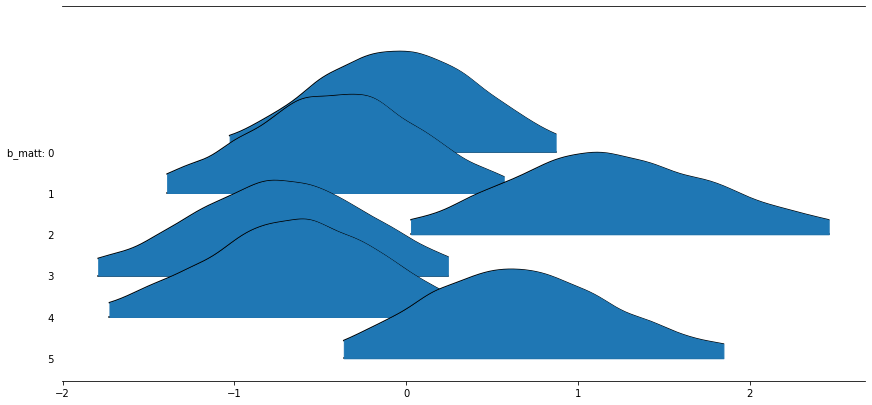

In [26]:
az.plot_forest(trace6, var_names='b_matt',
               combined=True, kind="ridgeplot",
              ridgeplot_truncate=True, 
               )

<AxesSubplot:>

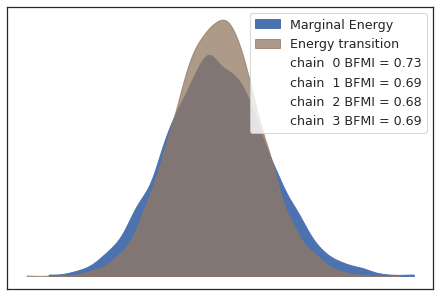

In [104]:
az.plot_energy(trace6)

In [28]:
trStacked = trace6.posterior.stack(draws=('chain','draw'))


#### Remember the order to use for comparison
'CSminus1':0, 'CSplus1':1, 'CSplusUS1':2, 'CSplus2':3, 'CSminus2':4, 'CSminusUS2':5

In [109]:
trStacked.b_cond.shape

(6, 8000)

In [34]:
csminus1 = trStacked.b_cond[0,:].values
csplus1 = trStacked.b_cond[1,:].values
csPlusUS1 = trStacked.b_cond[2,:].values
csminus2 = trStacked.b_cond[4,:].values
csplus2 = trStacked.b_cond[3,:].values
csPlusUS2 = trStacked.b_cond[5,:].values

<AxesSubplot:ylabel='Count'>

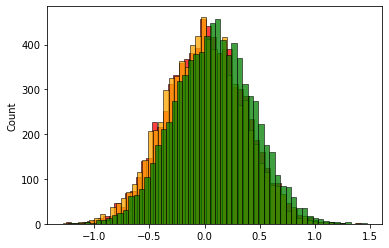

In [30]:
sns.histplot(csminus1, color='red')
sns.histplot(csplus1, color='orange')
sns.histplot(csPlusUS1, color='green')

Text(0.5, 1.0, 'CSPlusUS1-CSplus1')

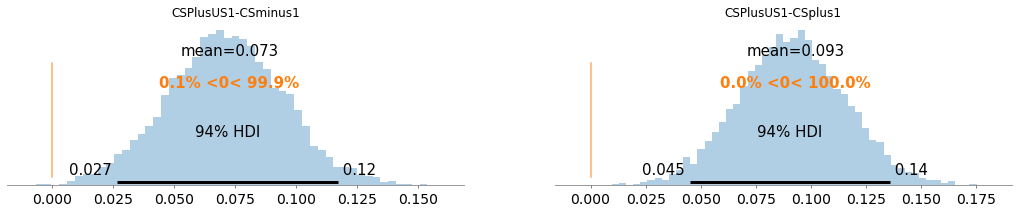

In [33]:
delta = csPlusUS1-csminus1
delta.shape

fig, axes = plt.subplots(1,2, figsize=(18,3), )
az.plot_posterior(delta, point_estimate='mean', kind='hist', ax=axes[0], ref_val=0)
axes[0].set_title("CSPlusUS1-CSminus1")

az.plot_posterior(csPlusUS1-csplus1, point_estimate='mean', kind='hist', ax=axes[1], ref_val=0)
axes[1].set_title("CSPlusUS1-CSplus1")


Text(0.5, 1.0, 'CSPlusUS2-CSplus2')

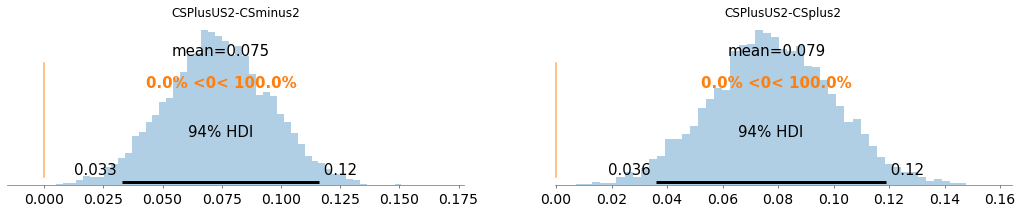

In [35]:
fig, axes = plt.subplots(1,2, figsize=(18,3), )
az.plot_posterior(csPlusUS2-csminus2, point_estimate='mean', kind='hist', ax=axes[0], ref_val=0)
axes[0].set_title("CSPlusUS2-CSminus2")

az.plot_posterior(csPlusUS2-csplus2, point_estimate='mean', kind='hist', ax=axes[1], ref_val=0)
axes[1].set_title("CSPlusUS2-CSplus2")

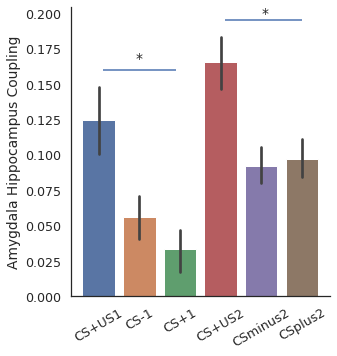

In [98]:
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='coupling',x='condition', data=df, kind='bar', ci=68)
g.set_xlabels("")
g.set_xticklabels(
    labels=["CS+US1", "CS-1", "CS+1", "CS+US2", "CSminus2", "CSplus2"], rotation=30)
plt.text(0.9, 0.165, "*")
plt.hlines(0.16, 0.1,1.9)
plt.text(4, 0.197, "*")
plt.hlines(0.195, 3.1,5)
g.set_ylabels("Amygdala Hippocampus Coupling")
g.savefig('coupling_different_Conditions.png', dpi=300, bbox_inches='tight')

In [135]:
# try same model with much more samples
with model6:  
    trace7 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=5000, tune=5000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 1214 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'a_matt'}>,
        <AxesSubplot:title={'center':'a_matt'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'b_matt'}>,
        <AxesSubplot:title={'center':'b_matt'}>],
       [<AxesSubplot:title={'center':'b_trials'}>,
        <AxesSubplot:title={'center':'b_trials'}>],
       [<AxesSubplot:title={'center':'b_amg'}>,
        <AxesSubplot:title={'center':'b_amg'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:t

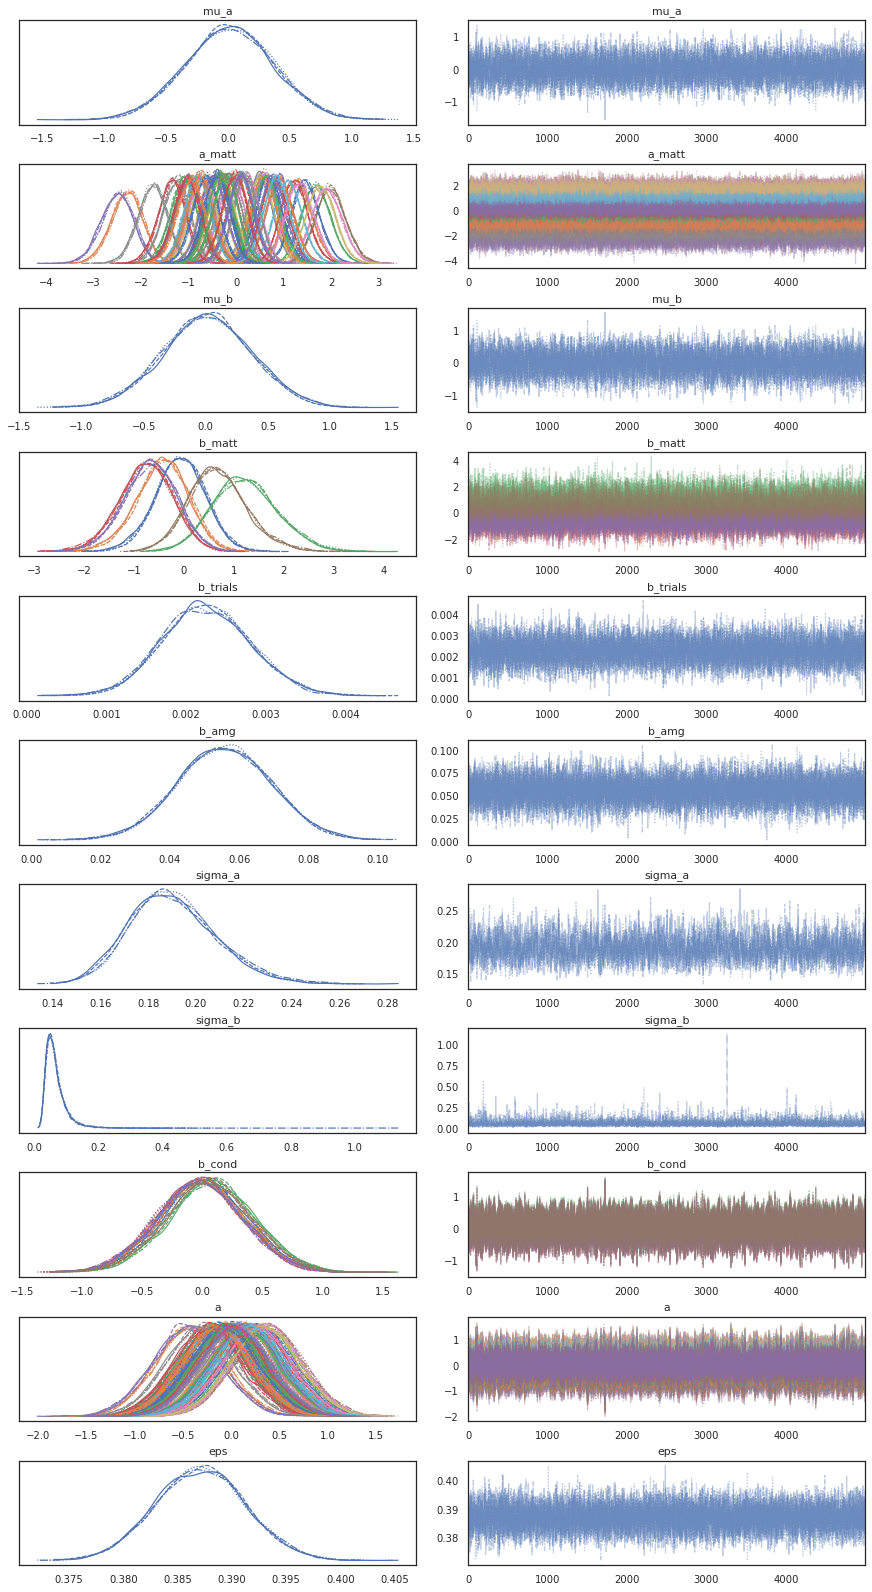

In [136]:
az.plot_trace(trace7)

In [137]:
trStacked2 = trace7.posterior.stack(draws=('chain','draw'))

In [138]:
csminus1 = trStacked2.b_cond[0,:].values
csplus1 = trStacked2.b_cond[1,:].values
csPlusUS1 = trStacked2.b_cond[2,:].values


<AxesSubplot:ylabel='Count'>

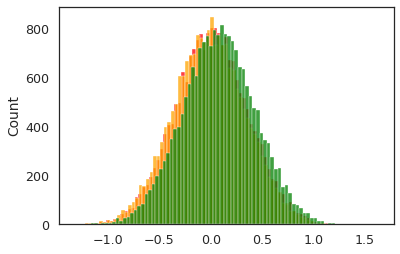

In [139]:
sns.histplot(csminus1, color='red')
sns.histplot(csplus1, color='orange')
sns.histplot(csPlusUS1, color='green')

Text(0.5, 1.0, 'CSPlusUS1-CSplus1')

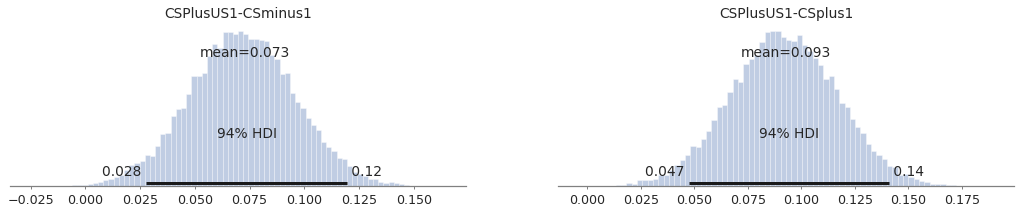

In [140]:
delta = csPlusUS1-csminus1
delta.shape

fig, axes = plt.subplots(1,2, figsize=(18,3))
az.plot_posterior(delta, point_estimate='mean', kind='hist', ax=axes[0])
axes[0].set_title("CSPlusUS1-CSminus1")

az.plot_posterior(csPlusUS1-csplus1, point_estimate='mean', kind='hist', ax=axes[1])
axes[1].set_title("CSPlusUS1-CSplus1")


In [141]:
az.summary(trace7, var_names=['b_matt','b_cond','mu_b','mu_a'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_matt[0] -0.069  0.503  -1.038    0.859      0.006    0.004    6492.0   
b_matt[1] -0.433  0.524  -1.438    0.528      0.007    0.005    6312.0   
b_matt[2]  1.230  0.650   0.022    2.455      0.008    0.005    7007.0   
b_matt[3] -0.762  0.535  -1.764    0.243      0.007    0.005    6035.0   
b_matt[4] -0.670  0.527  -1.665    0.316      0.007    0.005    6070.0   
b_matt[5]  0.679  0.586  -0.375    1.865      0.007    0.005    6892.0   
b_cond[0]  0.006  0.354  -0.661    0.672      0.004    0.002   10158.0   
b_cond[1] -0.014  0.354  -0.695    0.634      0.004    0.002   10153.0   
b_cond[2]  0.079  0.354  -0.580    0.752      0.004    0.002   10191.0   
b_cond[3] -0.034  0.354  -0.718    0.613      0.004    0.002   10242.0   
b_cond[4] -0.029  0.354  -0.708    0.624      0.004    0.002   10244.0   
b_cond[5]  0.046  0.354  -0.628    0.704      0.004    0.002   10145.0   
mu_b       0.010  0.354  -0.643    0.689      0.004    0.003    9939.0   
mu_a       0.016  0.353  -0.644    0.683      0.004    0.002   10168.0   

           ess_tail  r_hat  
b_matt[0]    9805.0    1.0  
b_matt[1]   10318.0    1.0  
b_matt[2]   10897.0    1.0  
b_matt[3]    9818.0    1.0  
b_matt[4]   10412.0    1.0  
b_matt[5]   10253.0    1.0  
b_cond[0]   12053.0    1.0  
b_cond[1]   12114.0    1.0  
b_cond[2]   12423.0    1.0  
b_cond[3]   11994.0    1.0  
b_cond[4]   11956.0    1.0  
b_cond[5]   12187.0    1.0  
mu_b        11919.0    1.0  
mu_a        12316.0    1.0

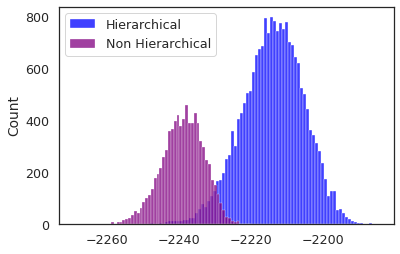

In [146]:
# calculate logP
logP = trace7.sample_stats.lp.stack(draws=('chain','draw'))
logP1 = trace2.sample_stats.lp.stack(draws=('chain','draw'))
sns.histplot(logP, label='Hierarchical', color='blue')
sns.histplot(logP1, label='Non Hierarchical', color='purple')
plt.legend()

### Posterior predictive checks

In [147]:
with model6:
    ppc = pm.sample_posterior_predictive(trace7)

In [152]:
az.from_pymc3(posterior_predictive=ppc, model=model6)

Inference data with groups:
	> posterior_predictive
	> observed_data

<AxesSubplot:xlabel='y'>

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


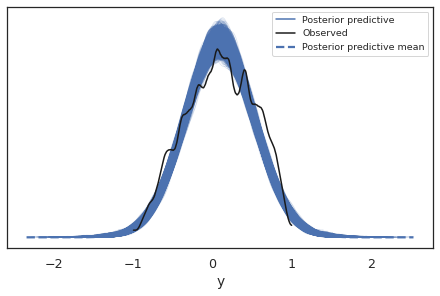

In [153]:
# plot
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model6), var_names='y')

## Next: Assessing SCR using coupling
- Now we will test SCR as predicted variable and coupling as predictor (independent)

In [124]:
glm2 = smf.mixedlm('scr~ coupling + C(condition) + trialNo+ amg', data=df, 
    groups = 'subject', 
                 missing='drop')
model2_f = glm2.fit()
print(model2_f.summary())

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     scr       
No. Observations:       4485        Method:                 REML      
No. Groups:             65          Scale:                  0.3783    
Min. group size:        69          Log-Likelihood:         -4330.8159
Max. group size:        69          Converged:              Yes       
Mean group size:        69.0                                          
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.447    0.067   6.686 0.000  0.316  0.578
C(condition)[T.CSminus2]    0.309    0.044   7.083 0.000  0.224  0.395
C(condition)[T.CSminusUS2]  0.519    0.045  11.459 0.000  0.431  0.608
C(condition)[T.CSplus1]     0.230    0.031   7.370 0.000  0.169  0.291
C(condition)[T.CSplus2]

## Bayes
- We are going to use the same model we chose (model6)

In [125]:
# use reparametarization of the same model
# add hyperpriors
with pm.Model() as model1_scr:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.scr)
   
    
    trace1_scr = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 429 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [49]:
az.summary(trace1_scr, var_names=['mu_a','b_coup', 'b_cond'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_a       0.361  0.357  -0.298    1.045      0.005    0.004    4984.0   
b_coup     0.056  0.024   0.010    0.101      0.000    0.000    8900.0   
b_cond[0]  0.077  0.358  -0.587    0.760      0.005    0.004    4867.0   
b_cond[1]  0.305  0.358  -0.353    0.995      0.005    0.004    4864.0   
b_cond[2]  0.729  0.359   0.051    1.405      0.005    0.004    4876.0   
b_cond[3]  0.289  0.360  -0.428    0.930      0.005    0.004    4863.0   
b_cond[4]  0.382  0.360  -0.285    1.074      0.005    0.004    4848.0   
b_cond[5]  0.590  0.360  -0.117    1.239      0.005    0.004    4867.0   

           ess_tail  r_hat  
mu_a         5180.0    1.0  
b_coup       6172.0    1.0  
b_cond[0]    5048.0    1.0  
b_cond[1]    5037.0    1.0  
b_cond[2]    5004.0    1.0  
b_cond[3]    4956.0    1.0  
b_cond[4]    5117.0    1.0  
b_cond[5]    4990.0    1.0

array([[<AxesSubplot:title={'center':'b_coup'}>,
        <AxesSubplot:title={'center':'b_cond\n0'}>,
        <AxesSubplot:title={'center':'b_cond\n1'}>],
       [<AxesSubplot:title={'center':'b_cond\n2'}>,
        <AxesSubplot:title={'center':'b_cond\n3'}>,
        <AxesSubplot:title={'center':'b_cond\n4'}>],
       [<AxesSubplot:title={'center':'b_cond\n5'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

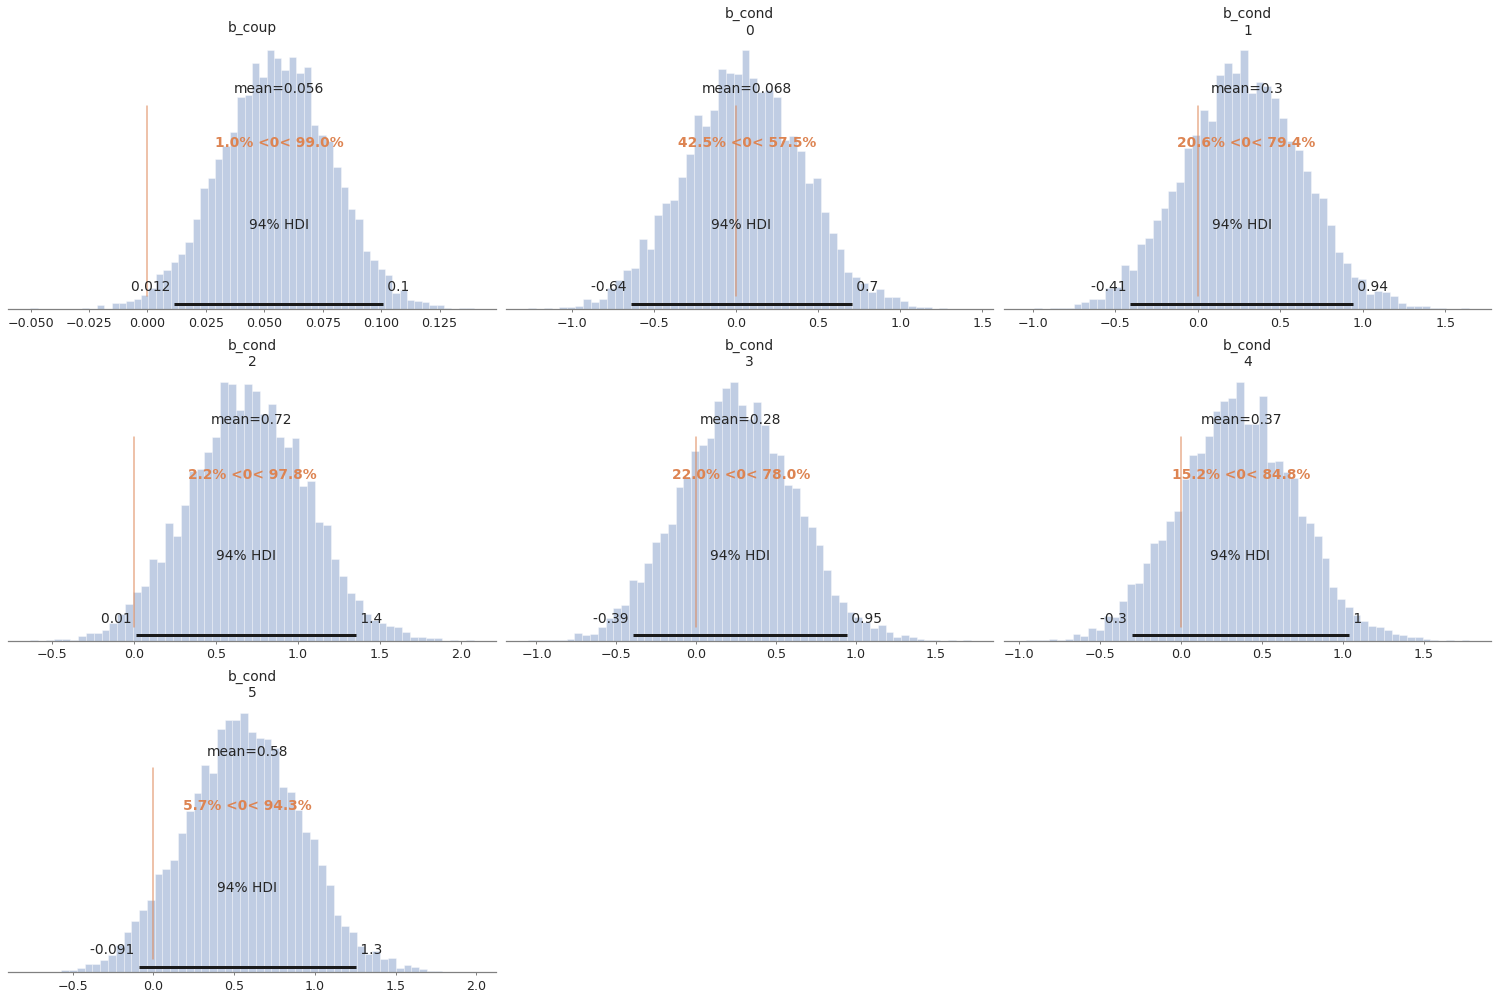

In [214]:
sns.set_style("ticks")
az.plot_posterior(trace1_scr, var_names=['b_coup','b_cond'], kind='hist', point_estimate='mean',
                 ref_val=0)


In [160]:
with model1_scr:
    ppc = pm.sample_posterior_predictive(trace1_scr)

<AxesSubplot:xlabel='y_hat'>

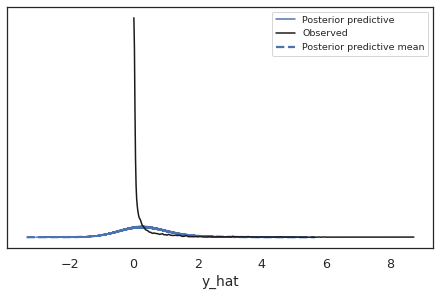

In [163]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model1_scr), var_names='y_hat')

## Prediction error and coupling

In [40]:
with pm.Model() as model1_pe:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace1_pe = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 68 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b_coup'}>,
        <AxesSubplot:title={'center':'b_coup'}>]], dtype=object)

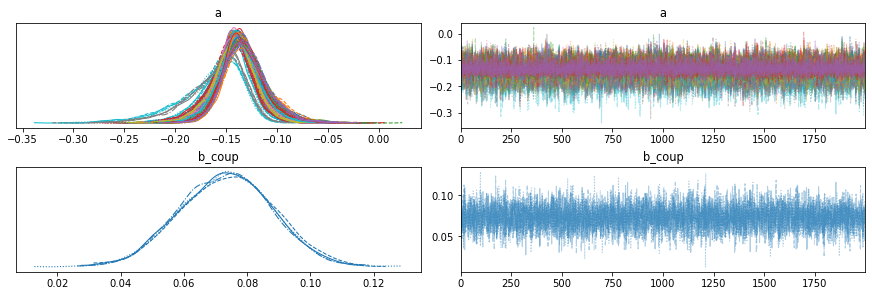

In [41]:
az.plot_trace(trace1_pe, var_names=['a', 'b_coup'])

In [64]:
az.summary(trace1_pe, var_names=['b_coup','b_amg','b_trials', 'mu_a'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_coup    0.073  0.015   0.046    0.100        0.0      0.0    8482.0   
b_amg    -0.006  0.015  -0.032    0.023        0.0      0.0    9801.0   
b_trials  0.001  0.000   0.001    0.002        0.0      0.0    5406.0   
mu_a     -0.139  0.013  -0.161   -0.115        0.0      0.0    5328.0   

          ess_tail  r_hat  
b_coup      5080.0    1.0  
b_amg       5741.0    1.0  
b_trials    5360.0    1.0  
mu_a        5181.0    1.0

Text(0.5, 1.0, 'Trial No')

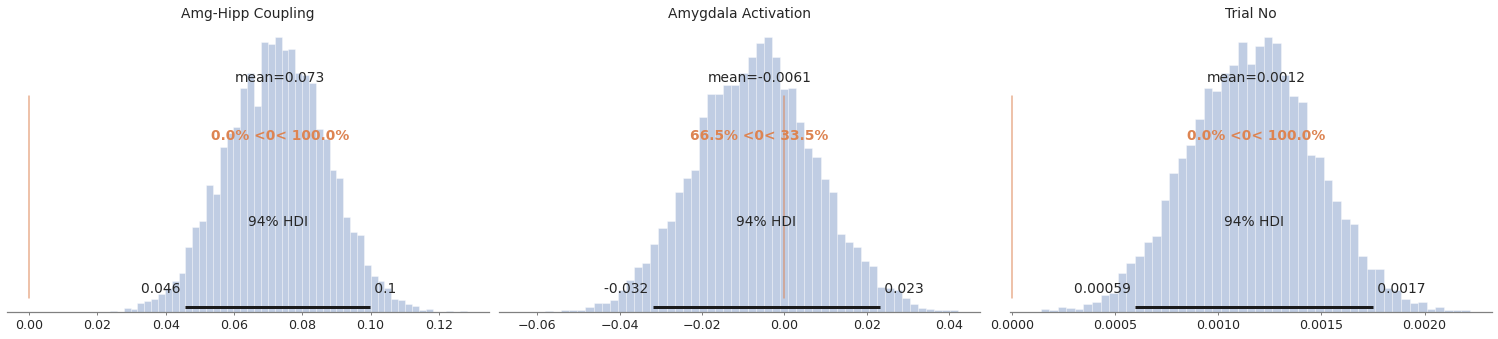

In [59]:
sns.set_style("ticks")
p = az.plot_posterior(trace1_pe, var_names=['b_coup','b_amg','b_trials'],
                 kind='hist', ref_val=0, point_estimate='mean')
p[0].set_title("Amg-Hipp Coupling")
p[1].set_title("Amygdala Activation")
p[2].set_title("Trial No")

In [178]:
with model1_pe:
    ppc = pm.sample_posterior_predictive(trace1_pe)

<AxesSubplot:xlabel='y_hat'>

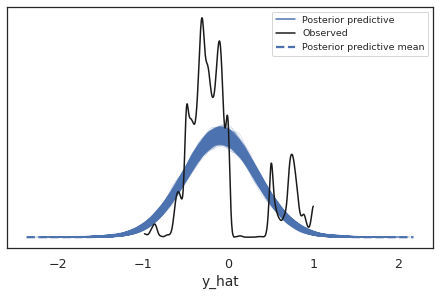

In [179]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model1_pe), var_names='y_hat')

### Using Dirchliet to account for the multiple distributions

In [20]:
with pm.Model() as model:
    w = pm.Dirichlet("w", [1,1])

    mu = pm.Normal(
        "mu",
        [0,0],
        1.0,
        shape=2,
        transform=pm.transforms.ordered,
        testval=[1, 2],
    )
    tau = pm.Gamma("tau", 1.0, 1.0, shape=2)

    x_obs = pm.NormalMixture("x_obs", w, mu, tau=tau, observed=df.pe)

In [21]:
with model:
    trDM = pm.sample()

/tmp/ipykernel_14259/1948356417.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trDM = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

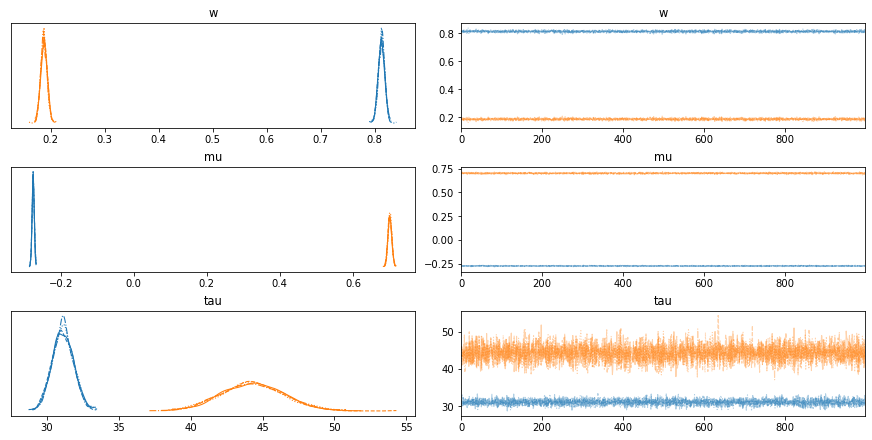

In [22]:
az.plot_trace(trDM)

n         r        CI95%     p-val     BF10     power
pearson  69  0.426161  [0.21, 0.6]  0.000261  102.554  0.960928

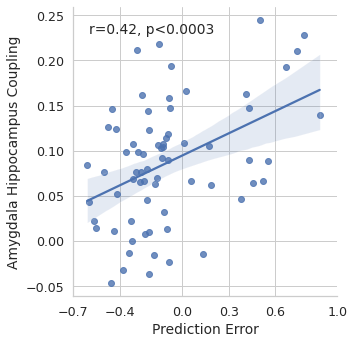

In [47]:
# plot results
forPlot = df.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("whitegrid")
a = sns.lmplot(x ='pe', y='coupling', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala Hippocampus Coupling")
plt.text(-0.6,0.23, "r=0.42, p<0.0003")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
a.savefig('pe_coupling.png', dpi=300, bbox_inches='tight')
pg.corr(forPlot['pe'], forPlot['coupling'])

In [ ]:
# ideas
#Ziv - PPI (should be similar to first result)
# Megha - test interaction of PE and alpha on associability
# Megha - histogram of correlation (replacing this one)

In [226]:
# build histogram of correlations:
from scipy import stats
r = []
for sub in df['sub'].unique():
    #print(sub)
    rsub = stats.pearsonr(df['coupling'][df['sub']==sub], df['pe'][df['sub']==sub])
    print(rsub)
    r.append(rsub[0])

(0.3046183637229226, 0.010930337093809505)
(0.09957295151211211, 0.4156275053646665)
(0.33548319811434124, 0.004832585260056897)
(0.26892739215546974, 0.02545643415867279)
(-0.036627215370884855, 0.7650999008751065)
(0.18759804833401994, 0.12269072962135093)
(-0.026999985394925104, 0.8256986349362365)
(0.25549003389908953, 0.034108210584151664)
(0.28413702253287143, 0.017976929058912183)
(-0.04325305503110104, 0.7241721681509811)
(0.23772944679941693, 0.049188873073852724)
(0.1262215003336709, 0.30138847451190764)
(-0.04463752783123829, 0.7157124632665524)
(0.25876916105361997, 0.03179780560874445)
(-0.04365515707246102, 0.7217117100897201)
(0.19395504287664458, 0.11029175591412274)
(0.0304317235966932, 0.803960897068722)
(0.08688187854529095, 0.47779436190043745)
(0.1624495634364958, 0.18232409229954158)
(0.11567747360393288, 0.34388474592067986)
(-0.0384804698939844, 0.7535821229271328)
(-0.16070467012805414, 0.18712962441682487)
(0.08516851059687089, 0.48655155380618315)
(0.05984901

0.08531058150884845

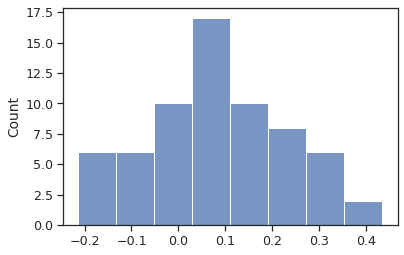

In [229]:
sns.histplot(r)
np.mean(r)
stats.ttest_1samp(r)

## Other Regions
- vmPFC

### General coupling

In [170]:
with pm.Model() as model1_vmpfc:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
   
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df['amg_vmpfc'])
    
    trace1_vmpfc = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 695 seconds.


array([[<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'b_matt'}>,
        <AxesSubplot:title={'center':'b_matt'}>]], dtype=object)

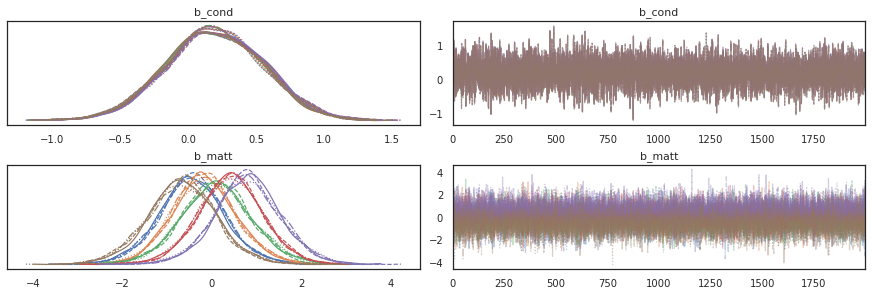

In [171]:
az.plot_trace(trace1_vmpfc, var_names=['b_cond', 'b_matt'])

In [172]:
trStackedvmPFC = trace1_vmpfc.posterior.stack(draws=('chain','draw'))


#### Remember the order to use for comparison
'CSminus1':0, 'CSplus1':1, 'CSplusUS1':2, 'CSplus2':3, 'CSminus2':4, 'CSminusUS2':5

In [173]:
trStackedvmPFC.b_cond.shape

(6, 8000)

In [174]:
csminus1 = trStackedvmPFC.b_cond[0,:].values
csplus1 = trStackedvmPFC.b_cond[1,:].values
csPlusUS1 = trStackedvmPFC.b_cond[2,:].values
csminus2 = trStackedvmPFC.b_cond[4,:].values
csplus2 = trStackedvmPFC.b_cond[3,:].values
csPlusUS2 = trStackedvmPFC.b_cond[5,:].values

<AxesSubplot:ylabel='Count'>

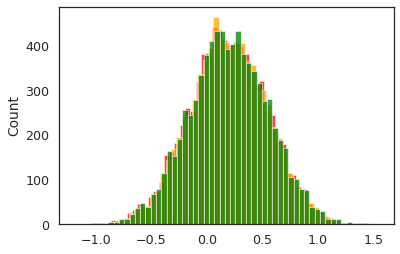

In [175]:
sns.histplot(csminus1, color='red')
sns.histplot(csplus1, color='orange')
sns.histplot(csPlusUS1, color='green')

Text(0.5, 1.0, 'CSPlusUS1-CSplus1')

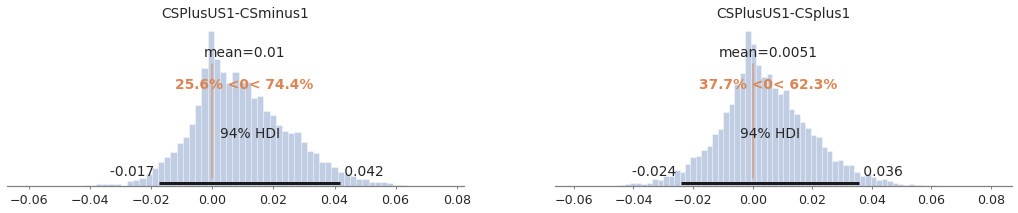

In [176]:
delta = csPlusUS1-csminus1
delta.shape

fig, axes = plt.subplots(1,2, figsize=(18,3), )
az.plot_posterior(delta, point_estimate='mean', kind='hist', ax=axes[0], ref_val=0)
axes[0].set_title("CSPlusUS1-CSminus1")

az.plot_posterior(csPlusUS1-csplus1, point_estimate='mean', kind='hist', ax=axes[1], ref_val=0)
axes[1].set_title("CSPlusUS1-CSplus1")


Text(0.5, 1.0, 'CSPlusUS2-CSplus2')

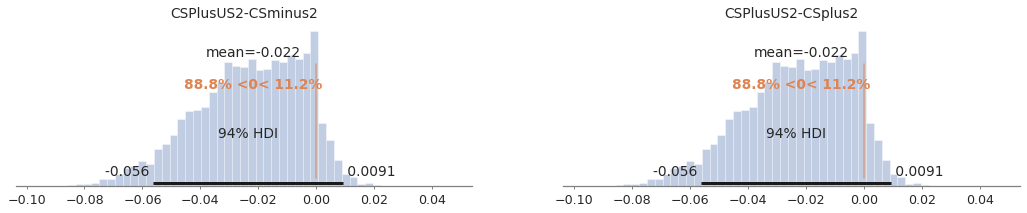

In [177]:
fig, axes = plt.subplots(1,2, figsize=(18,3), )
az.plot_posterior(csPlusUS2-csplus2, point_estimate='mean', kind='hist', ax=axes[0], ref_val=0)
axes[0].set_title("CSPlusUS2-CSminus2")

az.plot_posterior(csPlusUS2-csplus2, point_estimate='mean', kind='hist', ax=axes[1], ref_val=0)
axes[1].set_title("CSPlusUS2-CSplus2")

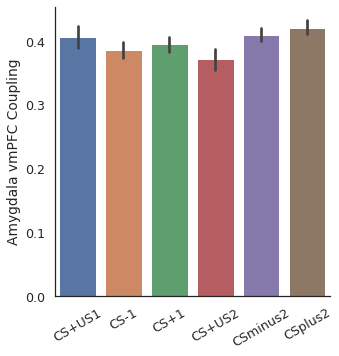

In [167]:
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='coupling',x='condition', data=dfvmpfc, kind='bar', ci=68)
g.set_xlabels("")
g.set_xticklabels(
    labels=["CS+US1", "CS-1", "CS+1", "CS+US2", "CSminus2", "CSplus2"], rotation=30)
g.set_ylabels("Amygdala vmPFC Coupling")
#g.savefig('coupling_different_Conditions.png', dpi=300, bbox_inches='tight')

### Behvarior (SCR)

In [107]:
df.head()

sub  Condition  Event.Nr  CDA.AmpSum  expected_value        pe     scr  \
0  sub-189  CSplusUS1         1      0.2852        0.775073  0.500000  0.2852   
1  sub-189   CSminus1         2      0.1033        0.772940 -0.500000  0.1033   
2  sub-189    CSplus1         3      0.0783        0.774003 -0.500680  0.0783   
3  sub-189  CSplusUS1         4      0.1772        0.775070  0.500002  0.1772   
4  sub-189   CSminus1         5      0.0000        0.771878 -0.499320  0.0000   

   index  subject  trialNo  condition  coupling       amg  amg_vmpfc  \
0   1794  sub-189        1  CSplusUS1  0.309524  0.981121   0.476190   
1   1795  sub-189        2   CSminus1 -0.571429 -0.027048   0.690476   
2   1796  sub-189        3    CSplus1 -0.476190 -0.045910   0.285714   
3   1797  sub-189        4  CSplusUS1  0.166667 -0.674150   0.547619   
4   1798  sub-189        5   CSminus1  0.214286 -0.065602   0.761905   

   amg_HippAnt  cond  
0     0.285714     2  
1    -0.047619     0  
2     0.428571     1  
3     0.357143     2  
4    -0.309524     0

In [134]:
n_sub

65

In [195]:
# use reparametarization of the same model
# add hyperpriors
with pm.Model() as scr_vmpfc:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    #mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_vmpfc)
    
    mu = a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_vmpfc
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.scr)
   
    
    trace1_scr_vmpfc = pm.sample(target_accept=.98, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [159]:
az.summary(trace1_scr_vmpfc, var_names=['b_coup','b_cond','b_matt'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_coup     0.017  0.026  -0.031    0.066      0.000    0.000    5077.0   
b_cond[0]  0.068  0.359  -0.598    0.759      0.007    0.005    2647.0   
b_cond[1]  0.288  0.359  -0.416    0.940      0.007    0.005    2665.0   
b_cond[2]  0.707  0.360   0.020    1.376      0.007    0.005    2644.0   
b_cond[3]  0.272  0.360  -0.396    0.963      0.007    0.005    2646.0   
b_cond[4]  0.363  0.360  -0.347    1.014      0.007    0.005    2641.0   
b_cond[5]  0.571  0.361  -0.095    1.269      0.007    0.005    2630.0   
b_matt[0] -1.152  0.581  -2.203   -0.032      0.016    0.011    1368.0   
b_matt[1] -0.288  0.437  -1.080    0.540      0.012    0.008    1335.0   
b_matt[2]  1.352  0.575   0.293    2.448      0.013    0.009    1919.0   
b_matt[3] -0.352  0.447  -1.209    0.462      0.012    0.009    1298.0   
b_matt[4]  0.005  0.419  -0.802    0.775      0.011    0.008    1360.0   
b_matt[5]  0.820  0.474  -0.047    1.708      0.012    0.008    1686.0   

           ess_tail  r_hat  
b_coup       5775.0    1.0  
b_cond[0]    4173.0    1.0  
b_cond[1]    4054.0    1.0  
b_cond[2]    4082.0    1.0  
b_cond[3]    4074.0    1.0  
b_cond[4]    4047.0    1.0  
b_cond[5]    4028.0    1.0  
b_matt[0]    2554.0    1.0  
b_matt[1]    2600.0    1.0  
b_matt[2]    2996.0    1.0  
b_matt[3]    2429.0    1.0  
b_matt[4]    2587.0    1.0  
b_matt[5]    3197.0    1.0

<AxesSubplot:title={'center':'b_coup'}>

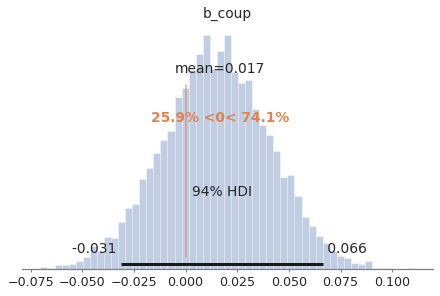

In [165]:
az.plot_posterior(trace1_scr_vmpfc,var_names=['b_coup'], kind='hist', ref_val=0, point_estimate='mean')

In [228]:
with pm.Model() as model1_pe_vmpfc:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=5)
    sigma_a = pm.HalfCauchy('sigma_a', 1)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=5)
     
    eps = pm.HalfCauchy('eps', 5)
    
    # make mu a determenistic distribution so we can test later vs. actual data  
    mu = pm.Deterministic('mu',a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_vmpfc)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
 
    trace1_pe_vmpfc = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


AssertionError: ('The following error happened while compiling the node', Elemwise{Composite{sqr((i0 - (i1 + (i2 * i3) + (i4 * i5) + (i6 * i7))))}}[(0, 1)](TensorConstant{[ 0.5     ...18996728]}, AdvancedSubtensor1.0, InplaceDimShuffle{x}.0, TensorConstant{[ 0.  1.  ... 67. 68.]}, InplaceDimShuffle{x}.0, TensorConstant{[ 0.981121...17744505]}, InplaceDimShuffle{x}.0, TensorConstant{[0.9047619...8       ]}), '\n')

In [213]:
az.summary(trace1_pe_vmpfc, var_names=['b_coup','b_amg','mu_a'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b_coup  0.074  0.015   0.046    0.100        0.0      0.0    7558.0    5615.0   
b_amg  -0.006  0.014  -0.033    0.020        0.0      0.0    9213.0    6031.0   
mu_a   -0.139  0.012  -0.162   -0.116        0.0      0.0    4500.0    5083.0   

        r_hat  
b_coup    1.0  
b_amg     1.0  
mu_a      1.0

array([<AxesSubplot:title={'center':'b_coup'}>,
       <AxesSubplot:title={'center':'b_amg'}>], dtype=object)

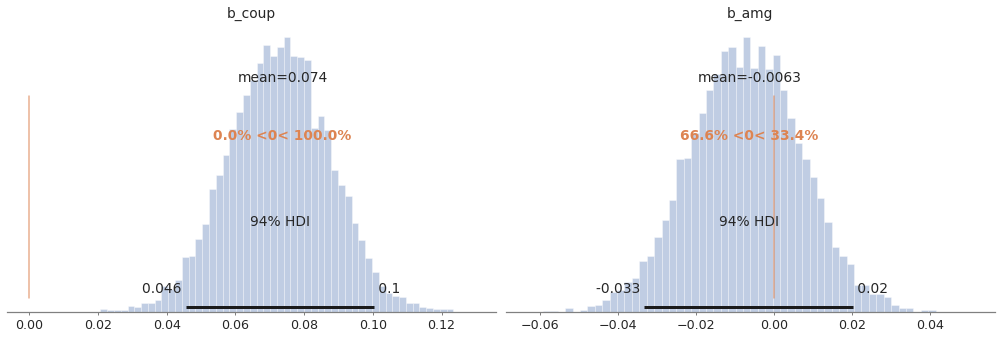

In [212]:
az.plot_posterior(trace1_pe_vmpfc, var_names=['b_coup','b_amg'], kind='hist',
                 ref_val=0)